In [2]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn

### Данные

In [3]:
DATASET_PATH = Path().absolute().parent / 'task1' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [4]:
import cv2

In [5]:
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_intro_ocr_t1.data.MidvPackage)

In [309]:
img = data_packs[3][0].image
template_img = data_packs[3].template_item.image

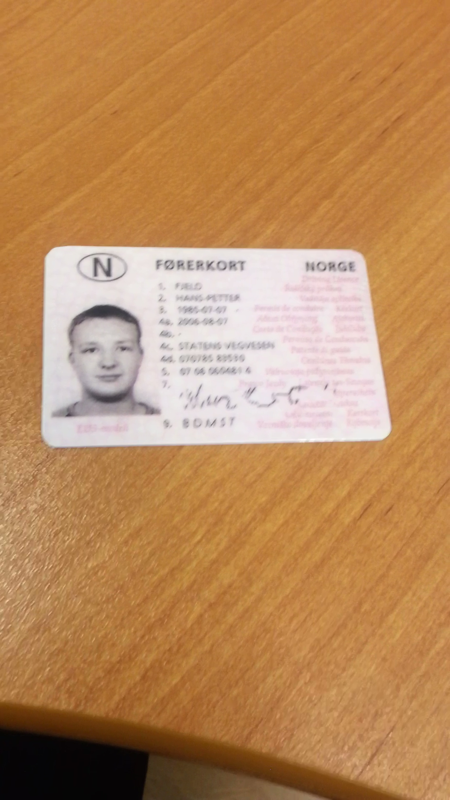

In [310]:
img

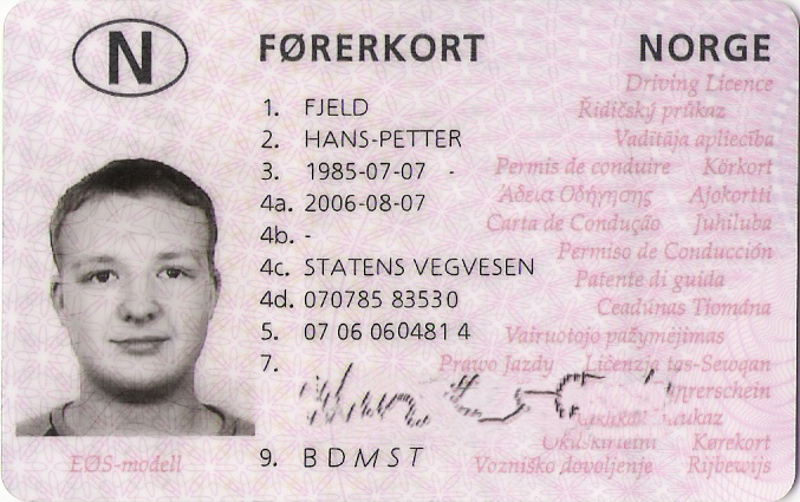

In [313]:
template_img

Будем использовать алгоритм на основе матчинга ключевых точек:

In [273]:
img = np.array(img)
template_img = np.array(template_img)
img_gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
template_img = cv2.cvtColor(template_img, cv2.IMREAD_GRAYSCALE)

In [274]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_gray, None)
kp2, des2 = sift.detectAndCompute(template_img, None)

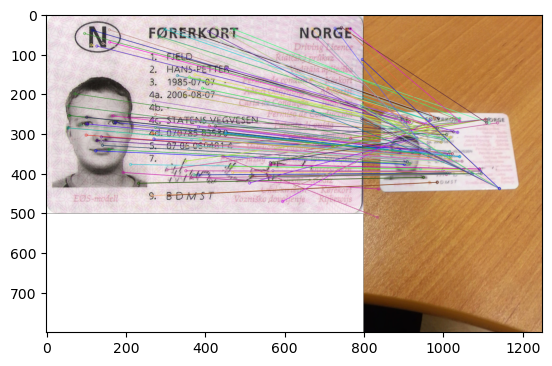

In [285]:
index_params = dict(algorithm = 0, trees = 5) 
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params) 
matches= flann.knnMatch(des2, des1, k=2)

#сортируем точки по расстоянию
good_points=[]
good_points_for_draw = []

alpha = 0.6
for m, n in matches:  
    if m.distance < alpha * n.distance: 
        good_points_for_draw.append([m])
        good_points.append(m)

final_img = cv.drawMatchesKnn(template_img, kp2, img_gray, kp1, good_points_for_draw, None)
plt.imshow(img3)

In [287]:
#ищем гомографию
query_pts = np.float32([kp2[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2) 
train_pts = np.float32([kp1[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2) 
    
matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
print(matrix)

[[ 4.33361835e-01 -1.36711384e-02  4.68921975e+01]
 [ 3.60450162e-02  3.08792224e-01  2.45197770e+02]
 [ 1.08708511e-04 -2.04586830e-04  1.00000000e+00]]


In [298]:
h_q, w_q, _ = template_img.shape 
pts = np.float32([[0, 0], [w_q, 0], [w_q, h_q], [0, h_q]]).reshape(-1, 1, 2) 
    
dst = cv2.perspectiveTransform(pts, matrix)

h, w, _ = img.shape
dst = dst / np.array([w, h])
dst

array([[[0.10420488, 0.30649721]],

       [[0.80464823, 0.31513586]],

       [[0.87311415, 0.5448835 ]],

       [[0.09913544, 0.55752342]]])

Сравним полученные данные с предсказанными:

In [302]:
dst.reshape(dst.shape[0], dst.shape[2]), data_packs[3][0].quadrangle

(array([[0.10420488, 0.30649721],
        [0.80464823, 0.31513586],
        [0.87311415, 0.5448835 ],
        [0.09913544, 0.55752342]]),
 array([[0.09777778, 0.305     ],
        [0.80888889, 0.31125   ],
        [0.87333333, 0.55      ],
        [0.09333333, 0.55875   ]]))

Посмотрим на результат:

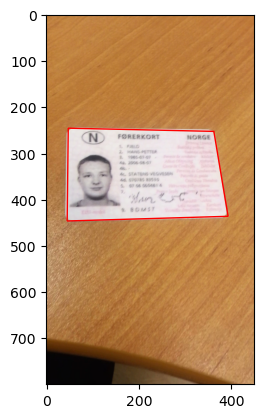

In [303]:
result = dst.reshape(dst.shape[0], dst.shape[2])
data_packs[3][0].show(result)

Обернем все вычисления в одну функцию:

In [193]:
def find_corners(template_img, main_img):
    template_img = np.array(template_img)
    main_img = np.array(main_img)
    
    main_gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kp_template, desc_template =sift.detectAndCompute(template_img, None)
    kp_main, desc_main = sift.detectAndCompute(main_gray, None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5) 
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params) 
    matches= flann.knnMatch(desc_template, desc_main, k=2) 
    
    good_points=[] 
  
    for i, (m, n) in enumerate(matches):  
        if(m.distance < 0.6*n.distance): 
            good_points.append(m) 
    
    query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2) 
    train_pts = np.float32([kp_main[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2) 
    
    matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0) 
  
    h_q, w_q, _ = template_img.shape 
    pts = np.float32([[0, 0], [w_q, 0], [w_q, h_q], [0, h_q]]).reshape(-1, 1, 2) 
    
    dst = cv2.perspectiveTransform(pts, matrix)
    h, w, _ = main_img.shape
    result = dst / np.array([w, h])
    
    return result.reshape(result.shape[0], result.shape[2])

In [304]:
find_corners(data_packs[5].template_item.image, data_packs[5][0].image)

array([[0.1357162 , 0.37474983],
       [0.87096049, 0.38241753],
       [0.88954217, 0.64548477],
       [0.06450356, 0.62766113]])

In [306]:
data_packs[5][0].quadrangle

array([[0.13333333, 0.3725    ],
       [0.86888889, 0.38      ],
       [0.88888889, 0.64625   ],
       [0.05777778, 0.625     ]])

### Тестируем:

In [194]:
results_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = find_corners(dp.template_item.image, dp[i].image)
            except Exception as exc:
                print(exc)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'



  2%|▊                                        | 1/50 [03:34<2:55:33, 214.98s/it]

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'



 50%|█████████████████████▌                     | 25/50 [16:44<14:33, 34.93s/it]

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'



 58%|████████████████████████▉                  | 29/50 [19:13<13:53, 39.69s/it]

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 66%|████████████████████████████▍              | 33/50 [24:19<14:31, 51.27s/it]

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'



 72%|██████████████████████████████▉            | 36/50 [30:05<18:02, 77.33s/it]

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'



 74%|███████████████████████████████▊           | 37/50 [30:32<13:28, 62.19s/it]

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspec

 84%|████████████████████████████████████       | 42/50 [35:07<05:57, 44.64s/it]

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 88%|█████████████████████████████████████▊     | 44/50 [36:13<03:52, 38.73s/it]

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'



 94%|████████████████████████████████████████▍  | 47/50 [37:43<01:38, 32.76s/it]

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input array

 96%|████████████████████████████████████████▎ | 48/50 [42:29<03:37, 108.78s/it]

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4

 98%|█████████████████████████████████████████▏| 49/50 [45:41<02:13, 133.57s/it]

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:550: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'

OpenCV(4.8.1) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'

OpenCV(4.8.1) /io/opencv/modules/core/src/matmul

100%|███████████████████████████████████████████| 50/50 [47:47<00:00, 57.35s/it]


In [195]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [196]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [197]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [198]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.9656
